# Short-term load forecasting based on time-series analysis of past load

In [0]:
#import packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU


#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

from sklearn import preprocessing



#read the file
df = pd.read_pickle('total_daily_ld')

#print the head


In [0]:
df.head() #net load per hour (in kWh)

,sum_total
0,19711.227
1,18916.294
2,18793.846
3,18995.577
4,18650.048


In [0]:
df['sum_inMW'] = (df['sum_total']/1000).round(2)

In [0]:
df.head  #net load per hour (MWh)

<bound method NDFrame.head of      sum_total  sum_inMW
0    19711.227     19.71
1    18916.294     18.92
2    18793.846     18.79
3    18995.577     19.00
4    18650.048     18.65
..         ...       ...
531  27079.350     27.08
532  25961.939     25.96
533  26689.071     26.69
534  26228.010     26.23
535  27020.115     27.02

[536 rows x 2 columns]>

In [0]:
# Preparing train and test sets
train=df[:300]
valid= df[300:]

In [0]:
#only consdering sum total in MW

dataset= df['sum_inMW']
#converting dataset into x_train and y_train
dataset= dataset.values.reshape(-1,1)

# Normalizing the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = preprocessing.StandardScaler().fit(dataset);
scaled_data = scaler.fit_transform(dataset)

In [0]:
scaled_data[:5]

array([[-0.83505005],
       [-1.05617319],
       [-1.09256055],
       [-1.03378098],
       [-1.13174693]])

In [0]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshaping x_train because LSTM accepts 3D input 

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [0]:
x_train.shape

(240, 60, 1)

In [0]:
# create and fit the LSTM network
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(GRU(units=50))
model.add(Dense(1))

#fititng the LSTM network

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





 - 13s - loss: 0.1462
Epoch 2/20
 - 11s - loss: 0.1187
Epoch 3/20
 - 11s - loss: 0.0943
Epoch 4/20
 - 11s - loss: 0.0859
Epoch 5/20
 - 11s - loss: 0.0833
Epoch 6/20
 - 11s - loss: 0.0865
Epoch 7/20
 - 11s - loss: 0.0680
Epoch 8/20
 - 11s - loss: 0.0746
Epoch 9/20
 - 11s - loss: 0.0851
Epoch 10/20
 - 11s - loss: 0.0649
Epoch 11/20
 - 11s - loss: 0.0558
Epoch 12/20
 - 11s - loss: 0.0608
Epoch 13/20
 - 12s - loss: 0.0608
Epoch 14/20
 - 11s - loss: 0.0559
Epoch 15/20
 - 11s - loss: 0.0691
Epoch 16/20
 - 11s - loss: 0.0596
Epoch 17/20
 - 11s - loss: 0.0504
Epoch 18/20
 - 11s - loss: 0.0480
Epoch 19/20
 - 11s - loss: 0.0486
Epoch 20/20
 - 11s - loss: 0.0651


In [0]:
#predicting test data values, using past 60 from the train data
inputs = df[len(df) - len(valid) - 60:]['sum_inMW']
inputs = inputs.values.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [0]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [0]:
X_test

array([[ 0.74640027,  0.4916888 ,  0.21458512, ..., -0.66151037,
        -0.92741795, -0.97500141],
       [ 0.4916888 ,  0.21458512, -0.17447965, ..., -0.92741795,
        -0.97500141, -0.59433372],
       [ 0.21458512, -0.17447965,  0.51408102, ..., -0.97500141,
        -0.59433372, -0.58033858],
       ...,
       [-0.22766117, -0.14648938,  0.51408102, ...,  1.76524614,
         1.22783293,  0.91434189],
       [-0.14648938,  0.51408102,  0.53927226, ...,  1.22783293,
         0.91434189,  1.11867087],
       [ 0.51408102,  0.53927226,  0.38252674, ...,  0.91434189,
         1.11867087,  0.98991563]])

In [0]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [0]:
#calculate rmse
 closing_price = np.reshape(closing_price, (np.product(closing_price.shape),))
rms=np.sqrt(((valid['sum_inMW']- closing_price) ** 2).mean())
rms

0.7455982307765808

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


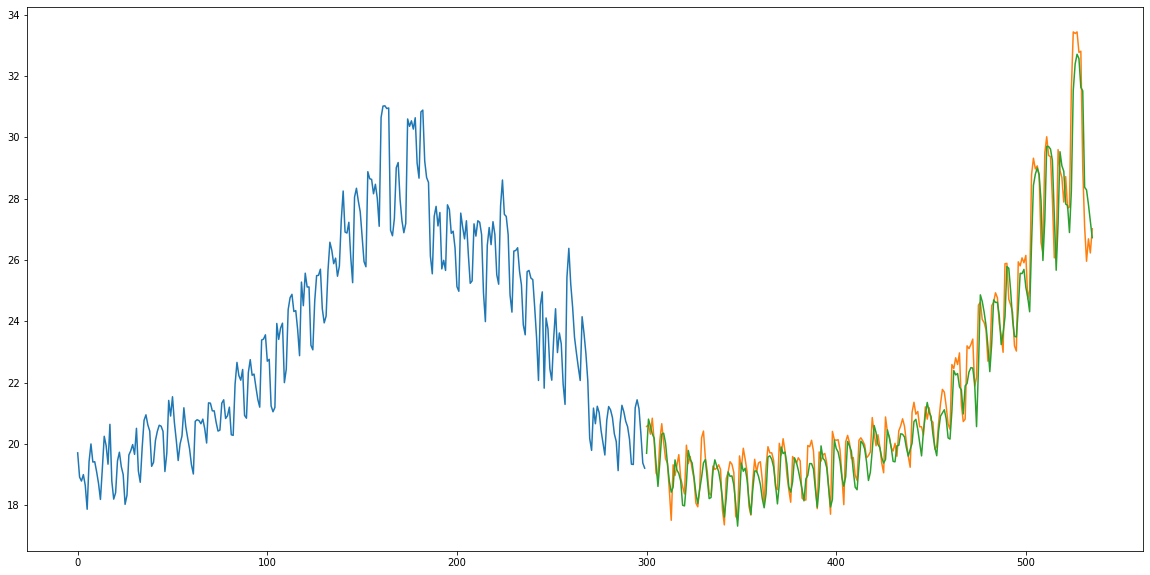

In [0]:
#plotting predicted values and actual values
train = df[:300]
valid = df[300:]
valid['Predictions'] = closing_price
plt.plot(train['sum_inMW'])
plt.plot(valid[['sum_inMW','Predictions']])
